In [2]:
%matplotlib inline

from __future__ import division
import numpy as np
import menpo.io as mio
from pathlib import Path
from menpo.image import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re
import sys
import menpo

In [3]:
import tensorflow as tf
from utils import caffe_preprocess, rescale_image
import convert

slim = tf.contrib.slim

tf.reset_default_graph()

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
sess = tf.InteractiveSession(config=config)

In [4]:
sys.path.append('/vol/atlas/homes/iasonas/mycaffe/python')
import caffe
caffe.set_mode_cpu()

In [5]:
## CHAOS

# BASE_PATH = Path('/vol/atlas/homes/iasonas/frcnn/experiments/nrm/snapshot_niters_100_snapshot_niters_10_nrm_its_10000_resol_1_2_4_bn_st_1_en_6_min_size_625_max_size_961_rawfc_ibug/')
# PROTOTXT_PATH = BASE_PATH / 'test.prototxt'

# # Take the latest iteration
# iteration, SNAPSHOT_PATH = max([(int(re.findall(r'iter_(\d+)', s.stem)[0]), str(s)) for s in (BASE_PATH / 'model').glob('*.caffemodel') if 'iter' in s.stem])
# print('Loading iteration {}...'.format(iteration))
# # BGR ordering

PROTOTXT_PATH = '/vol/atlas/homes/iasonas/frcnn/data/init/config/VGG16_raw/test.prototxt'
SNAPSHOT_PATH = '/vol/atlas/homes/iasonas/frcnn/data/init/weights/VGG16_raw.caffemodel'

net_caffe = caffe.Net(str(PROTOTXT_PATH), str(SNAPSHOT_PATH), caffe.TEST)

## Import image

In [9]:
original_image = mio.import_image('/vol/atlas/databases/afw/1130084326_1.jpg' , normalize=False)

rescaled_image = rescale_image(original_image)
input_pixels = caffe_preprocess(rescaled_image)

## Pass image through caffe net

In [10]:
# blobs = {'data': input_pixels[None, ...]}
# net_caffe.blobs['data'].reshape(*(blobs['data'].shape))
# net_caffe.blobs['data'].reshape(*blobs['data'].shape)
# net_caffe.reshape()
# blobs_out = net_caffe.forward_all(**blobs)

### Define TF model

In [11]:
import face_model

with sess.graph.as_default(), tf.variable_scope('net', reuse=False):
    with tf.contrib.slim.arg_scope([slim.layers.dropout], is_training=False):
        net = face_model.multiscale_net(input_pixels[None, ...].transpose(0, 2, 3, 1))

In [12]:
convert.assign_caffe_weights(net_caffe, sess)

ignoring upscore fuse layer


In [14]:
sess.run(tf.initialize_all_variables())

In [15]:
saver = tf.train.Saver()
saver.save(sess, 'raw_checkpoint', global_step=0)

'raw_checkpoint-0'

In [16]:
for output in tf.get_collection('outputs'):
    name = output.name.split('/')[-1]
    caffe_shape = net_caffe.blobs[name].data[0].shape
    tf_shape = np.array(output.outputs.get_shape().as_list()[1:])[[2, 0, 1]]
    if not all(tf_shape ==  caffe_shape):
        print "Layer {} is wrong".format(output.name[4:])
        print tf_shape, caffe_shape

Layer RS/conv1_1 is wrong
[ 64 641 833] (64, 224, 224)
Layer RS/conv1_2 is wrong
[ 64 641 833] (64, 224, 224)
Layer 1/RS/pool1 is wrong
[ 64 321 417] (64, 112, 112)
Layer RS/conv2_1 is wrong
[128 321 417] (128, 112, 112)
Layer RS/conv2_2 is wrong
[128 321 417] (128, 112, 112)
Layer 1/RS/pool2 is wrong
[128 161 209] (128, 56, 56)
Layer RS/conv3_1 is wrong
[256 161 209] (256, 56, 56)
Layer RS/conv3_2 is wrong
[256 161 209] (256, 56, 56)
Layer RS/conv3_3 is wrong
[256 161 209] (256, 56, 56)
Layer 1/RS/pool3 is wrong
[256  81 105] (256, 28, 28)
Layer RS/conv4_1 is wrong
[512  81 105] (512, 28, 28)
Layer RS/conv4_2 is wrong
[512  81 105] (512, 28, 28)
Layer RS/conv4_3 is wrong
[512  81 105] (512, 28, 28)
Layer 1/RS/pool4 is wrong
[512  81 105] (512, 14, 14)
Layer RS/conv5_1 is wrong
[512  81 105] (512, 14, 14)
Layer RS/conv5_2 is wrong
[512  81 105] (512, 14, 14)
Layer RS/conv5_3 is wrong
[512  81 105] (512, 14, 14)
Layer 1/RS/pool5 is wrong
[512  81 105] (512, 7, 7)


KeyError: 'cue5'

## Assign caffe weights to the TF model

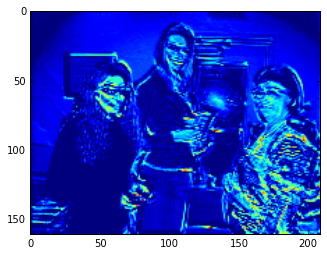

In [17]:
v = sess.graph.get_collection('outputs')[-11].outputs
plt.imshow(sess.run(v)[0, ..., 1])

In [10]:
# caffe_data = net_caffe.blobs['BN_pre_conv5_3'].data.transpose(0, 2, 3, 1)
# bn = net_caffe.blobs['conv5_3_scl'].data.transpose(0, 2, 3, 1)
# # print caffe_data.reshape(-1, 64).mean(0)[0], bn.reshape(-1, 64).mean(0)[0]

In [18]:
caffe_layers = {}

for i, layer in enumerate(net_caffe.layers):
    layer_name = net_caffe._layer_names[i]
    caffe_layers[layer_name] = layer

In [19]:
np.allclose(caffe_layers['conv1_1'].blobs[0].data, caffe_layers['conv1_1_RS4'].blobs[0].data)

KeyError: 'conv1_1_RS4'

In [20]:
n = sess.graph.get_tensor_by_name('net/upscore-fuse-nrm__00/BiasAdd:0')
tf_im = Image(sess.run(n)[0].transpose(2, 0, 1))
tf_im.normalize_std().view(channels='all', figure_size=(20, 20))

KeyError: "The name 'net/upscore-fuse-nrm__00/BiasAdd:0' refers to a Tensor which does not exist. The operation, 'net/upscore-fuse-nrm__00/BiasAdd', does not exist in the graph."

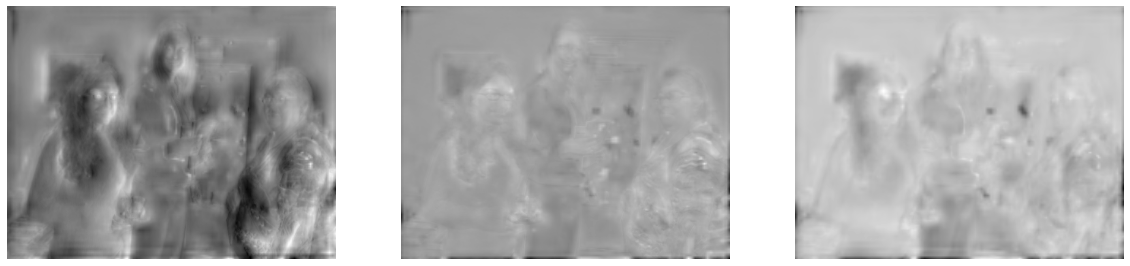

In [39]:
im = Image(net_caffe.blobs['upscore-fuse-nrm__00'].data[0])
im.normalize_std().view(channels='all', figure_size=(20, 20))

In [14]:
sess.graph.get_collection('outputs')[-1]

NamedOutputs(name='net/upscore-fuse-nrm__00', outputs=<tf.Tensor 'net/upscore-fuse-nrm__00/BiasAdd:0' shape=(1, 641, 833, 3) dtype=float32>)

In [16]:
for output in sess.graph.get_collection('outputs'):
    name = output.name.split('/')[-1]
    caffe_data = net_caffe.blobs[name].data.transpose(0, 2, 3, 1)
    tf_data = sess.run(output.outputs)
    if not np.allclose(caffe_data, tf_data, rtol=0.001, atol=0.001):
        norm = np.linalg.norm(caffe_data - tf_data)
        print "||{}|| is {:2f}".format(name, norm)
    else:
        norm = np.linalg.norm(caffe_data - tf_data)
        print "||{}|| is fine ({:2f})".format(name, norm)

||conv1_1|| is fine (0.006436)
||conv1_2|| is fine (0.216547)
||pool1|| is fine (0.133986)
||conv2_1|| is fine (0.368947)
||conv2_2|| is 0.686255
||pool2|| is fine (0.488005)
||conv3_1|| is 0.711736
||conv3_2|| is 0.811061
||conv3_3|| is 0.673382
||pool3|| is fine (0.460992)
||conv4_1|| is 0.392696
||conv4_2|| is fine (0.227620)
||conv4_3|| is fine (0.082149)
||pool4|| is fine (0.115560)
||conv5_1|| is fine (0.048346)
||conv5_2|| is fine (0.026296)
||conv5_3|| is fine (0.012496)
||pool5|| is fine (0.014942)
||cue5|| is fine (0.009612)
||fc6|| is fine (0.000000)
||fc7|| is fine (0.000000)
||score_nrm_6_0_hole0|| is fine (0.000000)
||BN_pre_conv1_2|| is 3289.103516
||score_nrm_1_0_hole0|| is 98599.687500
||BN_pre_conv2_2|| is 1651.709839
||score_nrm_2_0_hole0|| is 18080.238281
||BN_pre_conv3_3|| is 886.226929
||score_nrm_3_0_hole0|| is 10450.632812
||BN_pre_conv4_3|| is 246.229965
||score_nrm_4_0_hole0|| is 2137.792725
||BN_pre_conv5_3|| is 221.123901
||score_nrm_5_0_hole0|| is 1534.6607

In [186]:
out = tf.nn.conv2d(im, c1.reshape(3, 3, 3, 64), strides=(1, 1, 1, 1), padding='VALID')
out = sess.run(out)

In [187]:
out.shape

(1, 639, 831, 64)

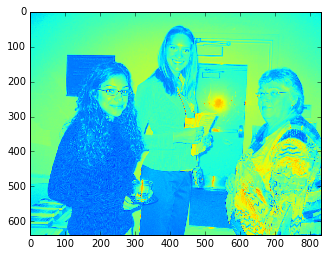

In [188]:
plt.imshow(out[0, ..., 1])


In [95]:
from scipy.signal import convolve2d

In [75]:
with tf.variable_scope("net", reuse=True):
    w = sess.run(tf.get_variable('{}/weights'.format('conv1_1')))

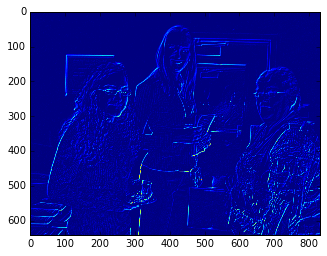

In [214]:
plt.imshow(net_caffe.blobs['conv1_1'].data[0, 0])

In [58]:
for output in net.graph.get_collection('outputs'):
    caffe_shape = net_caffe.blobs[output.name[4:]].data[0].shape
    tf_shape = np.array(output.outputs.get_shape().as_list()[1:])[[2, 0, 1]]
    if not all(tf_shape ==  caffe_shape):
        print "Layer {} is wrong".format(output.name[4:])
        print tf_shape, caffe_shape
        

In [60]:
layer = mapping.values()[0]
layer.blobs

In [12]:
caffe_layers.values()[0].blobs[0].data